In [ ]:
!pip3 install pandas openpyxl bertopic setuptools 'numpy<2' nltk spacy textstat textblob torch matplotlib ace_tools 
# add this to terminal every time - source .venv/bin/activate
#!pip3 install --upgrade pip

# IMPORT DATA - separate files country wise
Combine all the data 

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path

# 1. Set folder path and list files
folder_path = "/Users/vinitavader/Desktop/WJC/data"
file_paths = list(Path(folder_path).glob("*.xlsx"))

# 2. Set of countries that have translated responses
translated_countries = {"Brazil", "China", "Colombia", "Kazakhastan", "Poland", "Turkey"}

# 3. Process each file
def process_file(file_path):
    country = file_path.name.split('_')[0]  # Preserve original casing

    try:
        df = pd.read_excel(file_path)

        # 4. Define column pattern depending on translation status
        if country in translated_countries:
            # Look for _EN columns only
            lb_cols = [col for col in df.columns if re.match(r"LB_Open_Q[1-7]_EN$", col, flags=re.IGNORECASE)]
            smb_cols = [col for col in df.columns if re.match(r"SMB_Open_Q[1-7]_EN$", col, flags=re.IGNORECASE)]
        else:
            # Use standard non-EN columns
            lb_cols = [col for col in df.columns if re.match(r"LB_Open_Q[1-7]$", col, flags=re.IGNORECASE)]
            smb_cols = [col for col in df.columns if re.match(r"SMB_Open_Q[1-7]$", col, flags=re.IGNORECASE)]

        selected_cols = lb_cols + smb_cols
        if not selected_cols:
            print(f"⚠️ Skipping {file_path.name}: no relevant columns found")
            return None

        df = df[selected_cols].copy()

        # 5. Remove "_EN" suffix if present
        df.columns = [re.sub(r"_EN$", "", col, flags=re.IGNORECASE) for col in df.columns]

        # 6. Add pID and country
        df.insert(0, "pID", [f"{country}_p{i+1}" for i in range(len(df))])
        df.insert(1, "country", country)

        return df

    except Exception as e:
        print(f"❌ Skipping file {file_path.name}: {e}")
        return None

# 7. Collect all valid dataframes
dfs = []
for file_path in file_paths:
    df = process_file(file_path)
    if df is not None:
        if df.columns.duplicated().any():
            print(f"⚠️ Duplicate columns in {file_path.name}:")
            print(df.columns[df.columns.duplicated()].tolist())
        else:
            dfs.append(df)

# 8. Combine into one dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# 8. Replace empty strings with NaN
lb_cols = [f"LB_Open_Q{i}" for i in range(1, 8)]
smb_cols = [f"SMB_Open_Q{i}" for i in range(1, 8)]
combined_df[lb_cols + smb_cols] = combined_df[lb_cols + smb_cols].replace('', pd.NA)

# 9. Create Open_Q1 to Q7 using LB fallback to SMB
for i in range(1, 8):
    combined_df[f"Open_Q{i}"] = (
        combined_df.get(f"LB_Open_Q{i}").fillna(combined_df.get(f"SMB_Open_Q{i}")).astype(str)
    )

# 10. Unite Q1–Q7 and Q1–Q7_no6
open_q1_7_no6 = [f"Open_Q{i}" for i in range(1, 8) if i != 6]
open_q1_7 = [f"Open_Q{i}" for i in range(1, 8)]

combined_df["Open_Q1_Q7_no6"] = combined_df[open_q1_7_no6].apply(lambda row: ' '.join(row.dropna()), axis=1)
combined_df["Open_Q1_Q7"] = combined_df[open_q1_7].apply(lambda row: ' '.join(row.dropna()), axis=1)

# 11. Final dataframe selection
text_combined_df = combined_df[['pID', 'country'] + lb_cols + smb_cols + ['Open_Q1_Q7_no6', 'Open_Q1_Q7']]

text_combined_df

# IMPORT DATA - Merged files
Merged data sent by Berke 

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path

def clean_text(text):
    """Clean XML artifacts from text while preserving NA handling"""
    if pd.isna(text) or text == 'nan':
        return pd.NA
    
    # Convert to string and clean XML artifacts
    text = str(text)
    
    # Remove XML space preserve tags and entities
    text = re.sub(r'xml:space="preserve">', '', text)
    text = re.sub(r'&#xa;', ' ', text)  # Replace line breaks with spaces
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)  # Remove other XML entities
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Return NA if text becomes empty after cleaning
    return pd.NA if text == '' else text

# Load data
merged_df = (
    pd.read_csv("/Users/vinitavader/Desktop/WJC/data/WJC_firstwave_merged.csv")
    .pipe(lambda df: df.assign(
        **{col: df[col].replace('', pd.NA).apply(clean_text) for col in [f"LB_Open_Q{i}" for i in range(1, 8)] + [f"SMB_Open_Q{i}" for i in range(1, 8)] if col in df.columns}
    ))
    .pipe(lambda df: df.assign(
        **{
            f"Open_Q{i}": (
                df.get(f"LB_Open_Q{i}").fillna(df.get(f"SMB_Open_Q{i}"))
                # No need to apply clean_text again since original columns are already cleaned
            )
            for i in range(1, 8)
        }
    ))
    .pipe(lambda df: df.assign(
        Open_Q1_Q7_no6=df[[f"Open_Q{i}" for i in range(1, 8) if i != 6]]
            .apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1),
        Open_Q1_Q7=df[[f"Open_Q{i}" for i in range(1, 8)]]
            .apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
    ))
    # .loc[:, ['pID', 'country'] + 
    #      [f"LB_Open_Q{i}" for i in range(1, 8)] + 
    #      [f"SMB_Open_Q{i}" for i in range(1, 8)] + 
    #      ['Open_Q1_Q7_no6', 'Open_Q1_Q7']]
)

# Check the results
#print(merged_df.loc[:, ['pID', 'LB_Open_Q1', 'Open_Q1_Q7_no6', 'Open_Q1_Q7']])

In [ ]:
merged_df.columns

# TEXT CLASSIFICATION for the life domains

**What are the domains that people talk about when it comes to difficult life decisions?**

When individuals are asked to describe the most difficult decisions they have faced, I expected their responses to cluster around key life domains. These domains represent the major areas of life that people find most meaningful, challenging, or consequential when making important choices. Common domains include:

- **Family:** Decisions involving parents, children, siblings, or extended family, such as marriage, divorce, caregiving, or family responsibilities.
- **Career/Work:** Choices about jobs, career changes, promotions, work-life balance, or starting a business.
- **Relationships:** Romantic relationships, friendships, or social connections, including decisions about commitment, breakups, or maintaining relationships.
- **Health:** Personal or family health issues, medical treatments, mental health, or lifestyle changes affecting well-being.
- **Financial:** Decisions about money management, debt, investments, major purchases, or financial security.
- **Education:** Choices related to schooling, higher education, degrees, or lifelong learning.
- **Location:** Moving to a new city or country, relocating for work or family, or decisions about where to live.
- **Ethical/Moral:** Dilemmas involving values, principles, right and wrong, or situations that test personal integrity.

These domains capture the broad spectrum of challenges people encounter and highlight the areas where cultural, social, and personal values most strongly influence decision-making. By analyzing which domains are most frequently mentioned, we could gain insight into what people find most difficult or significant in their lives, and how these priorities may differ across cultures or contexts.

Two text classification-based approaches were chosen for doing this: 1. LLM-based approach and 2. Count-based approach.

In [ ]:
# --- Task 1: Count-Based Category Detection ---
import pandas as pd

# Define keyword-based decision categories
DEC_CATS = {
    'career':      ['job','work','career','profession','employment','business'],
    'relationships':['relationship','marriage','divorce','dating','partner','love'],
    'family':      ['family','children','parents','siblings','relatives'],
    'health':      ['health','medical','illness','doctor','treatment','surgery'],
    'financial':   ['money','financial','investment','debt','loan','purchase'],
    'education':   ['school','university','education','degree','study'],
    'location':    ['move','relocate','city','country','home','house'],
    'ethical':     ['right','wrong','moral','ethical','values','principle']
}

# Keyword count function
def decision_cats(text):
    if pd.isna(text):
        return {f"count_cat_{cat}": 0 for cat in DEC_CATS.keys()}
    
    text_l = str(text).lower()
    return {f"count_cat_{cat}": sum(text_l.count(kw) for kw in kws) for cat, kws in DEC_CATS.items()}

# Apply count-based classifier
count_df = merged_df["Open_Q1_Q7"].apply(decision_cats).apply(pd.Series)

# Add top count-based category
merged_df["count_category"] = count_df.idxmax(axis=1).str.replace("count_cat_", "")

# Combine results
merged_df = pd.concat([merged_df, count_df], axis=1)

# Preview
print(merged_df[["Open_Q1_Q7", "count_category"] + list(count_df.columns)])

# Save (optional)
#merged_df.columns.to_excel("count_based_classification.xlsx", index=False)

Checking if all the country data is matching the previous zero shot classification analysis 
1. Bazil (YES)
2. Canada (YES)
3. China (YES)
4. Colombia (YES)
5. Kazakhstan (YES)
6. Poland (YES)
7. Turkey (YES)
8. India (YES)
9. SriLanka (YES)

In [ ]:
import pandas as pd

def compare_country_data(country_name):
    """
    Compare Open_Q1_Q7 data between merged_df and zero-shot Excel file for a specific country
    Shows summary stats and returns only the mismatched rows
    
    Parameters:
    country_name (str): Name of the country to compare (e.g., 'Brazil', 'USA', 'India')
    
    Returns:
    DataFrame: Only the rows with mismatches
    """
    
    # Get country data from merged_df
    merged_country = merged_df.loc[merged_df['country'] == country_name][['pID', 'Open_Q1_Q7']].reset_index(drop=True)
    
    # Construct Excel file path
    excel_file = f"/Users/vinitavader/Desktop/WJC/scripts/llm_zero_shot_{country_name}.xlsx"
    
    # Load the zero shot data
    try:
        zero_shot_df = pd.read_excel(excel_file)
        zero_shot_country = zero_shot_df[['pID', 'Open_Q1_Q7']].reset_index(drop=True)
    except FileNotFoundError:
        print(f"File not found: {excel_file}")
        return None
    except Exception as e:
        print(f"Error loading file: {e}")
        return None
    
    # Check if both dataframes have the same length
    if len(merged_country) != len(zero_shot_country):
        print(f"Warning: Different number of rows - merged: {len(merged_country)}, zero_shot: {len(zero_shot_country)}")
    
    # Handle different lengths by taking the minimum length
    min_len = min(len(merged_country), len(zero_shot_country))
    merged_country = merged_country.iloc[:min_len].reset_index(drop=True)
    zero_shot_country = zero_shot_country.iloc[:min_len].reset_index(drop=True)
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'merged_pID': merged_country['pID'].values,
        'merged_Open_Q1_Q7': merged_country['Open_Q1_Q7'].values,
        'zero_shot_pID': zero_shot_country['pID'].values,
        'zero_shot_Open_Q1_Q7': zero_shot_country['Open_Q1_Q7'].values,
        'match_Open_Q1_Q7': merged_country['Open_Q1_Q7'].values == zero_shot_country['Open_Q1_Q7'].values,
        'match_pID': merged_country['pID'].values == zero_shot_country['pID'].values
    })
    
    # Print summary
    total_rows = len(comparison_df)
    text_matches = comparison_df['match_Open_Q1_Q7'].sum()
    pid_matches = comparison_df['match_pID'].sum()
    
    print(f"Country: {country_name}")
    print(f"Total rows: {total_rows}")
    print(f"Text matches: {text_matches} ({text_matches/total_rows*100:.1f}%)")
    print(f"pID matches: {pid_matches} ({pid_matches/total_rows*100:.1f}%)")
    print(f"Text mismatches: {total_rows - text_matches}")
    
    # Return only mismatches
    mismatches = comparison_df.query("match_Open_Q1_Q7 == False")
    print(f"\nReturning {len(mismatches)} mismatched rows:")
    return mismatches

# Example usage:
# mismatches = compare_country_data('Brazil')
# mismatches = compare_country_data('USA')

In [ ]:
pd.set_option('display.max_rows', None)
# Example usage:
compare_country_data('Kazakhstan')

# 1. LLM-based Zero-Shot Text Classification Approach
## Methodology
A zero-shot classification approach was used to assign life domain categories (e.g., family, career, health) to open-ended survey responses, without requiring any labeled training data. This was implemented using the Hugging Face transformers pipeline with the facebook/bart-large-mnli model.

How it works:

For each text response, the model is given a set of candidate labels (e.g., "career", "family", "health", etc.).
The model reformulates the classification task as a series of natural language inference (NLI) problems: for each label, it asks, “Does this text entail the label?”
The model outputs a probability score for each label, representing the likelihood that the text belongs to that category.
The label with the highest probability is selected as the predicted category, but all probabilities are retained for further analysis.
How probabilities are computed:

Under the hood, the model computes the probability that the text “entails” each label using its NLI head.
For each label, the text and label are paired and passed through the model, which outputs a softmax probability over entailment, contradiction, and neutral.
The entailment probability is used as the score for that label.

In [ ]:
from transformers import pipeline
import pandas as pd
import time
import numpy as np

# Define categories
DEC_CATS = {
    'career': [], 'relationships': [], 'family': [], 'health': [],
    'financial': [], 'education': [], 'location': [], 'ethical': []
}
candidate_labels = list(DEC_CATS.keys())

# Load zero-shot classifier once
zsc = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=-1  # Use CPU
)

def run_llm_classification_by_country(country_name, save=True, batch_size=50):
    df_country = merged_df[merged_df["country"] == country_name].copy()
    texts = df_country["Open_Q1_Q7"].tolist()
    all_results = []
    total = len(texts)
    
    for i in range(0, total, batch_size):
        batch = texts[i:i + batch_size]
        
        # Filter out NaN, None, and empty strings
        valid_batch = []
        batch_indices = []
        
        for idx, text in enumerate(batch):
            if pd.notna(text) and text and str(text).strip():
                valid_batch.append(str(text))
                batch_indices.append(idx)
        
        # Process batch results
        batch_results = []
        
        if valid_batch:  # Only process if there are valid texts
            try:
                res = zsc(valid_batch, candidate_labels=candidate_labels, multi_label=True)
                
                # Create results for the entire batch (including NaN positions)
                valid_idx = 0
                for idx in range(len(batch)):
                    if idx in batch_indices:
                        batch_results.append(res[valid_idx])
                        valid_idx += 1
                    else:
                        # Create dummy result for invalid/empty texts (will be handled later)
                        batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
                        
                print(f"[{time.ctime()}] Processed {min(i + batch_size, total)} / {total} for {country_name}")
                
            except Exception as e:
                print(f"⚠️ Batch {i}-{i + batch_size} failed: {e}")
                # Create dummy results for entire failed batch
                for _ in range(len(batch)):
                    batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
        else:
            print(f"⚠️ Batch {i}-{i + batch_size} skipped: no valid texts")
            # Create dummy results for entire batch of invalid texts
            for _ in range(len(batch)):
                batch_results.append({'labels': candidate_labels, 'scores': [0.0] * len(candidate_labels)})
        
        all_results.extend(batch_results)
    
    # Extract predictions (keeping original structure)
    df_country["llm_category"] = [r["labels"][0] for r in all_results]
    
    # Create score dataframe (keeping original structure)
    score_df = pd.DataFrame([
        {f"llm_cat_{label}": score for label, score in zip(r["labels"], r["scores"])}
        for r in all_results
    ])
    
    # Now replace with NA where original text was NA/empty
    na_mask = df_country["Open_Q1_Q7"].isna() | (df_country["Open_Q1_Q7"] == '') | (df_country["Open_Q1_Q7"].astype(str).str.strip() == '')
    
    # Reset index to match score_df
    df_country = df_country.reset_index(drop=True)
    na_mask = na_mask.reset_index(drop=True)
    
    # Set llm_category to NA for empty texts
    df_country.loc[na_mask, "llm_category"] = np.nan
    
    # Set all score columns to NA for empty texts
    score_cols = [f"llm_cat_{label}" for label in candidate_labels]
    for col in score_cols:
        score_df.loc[na_mask, col] = np.nan
    
    df_country = pd.concat([df_country, score_df], axis=1)
    
    if save:
        filename = f"llm_zero_shot_{country_name}.xlsx"
        df_country.to_excel(filename, index=False)
        print(f"✔ Finished and saved: {filename}")
    
    return df_country

In [ ]:
# Run the classification
turkey_df = run_llm_classification_by_country("SriLanka")

In [ ]:
import pandas as pd
import glob
import os


def combine_all_countries():
    countries = ['USA', 'UK', 'Canada', 'Poland', 'China', 'Colombia','Brazil', 'Kazakhstan', 'India', 'Turkey', 'SriLanka']  # Add all your countries here
    
    dfs = []
    for country in countries:
        file_path = f"/Users/vinitavader/Desktop/WJC/scripts/llm_zero_shot_{country}.xlsx"
        try:
            df = pd.read_excel(file_path)
            dfs.append(df)
            print(f"✓ Loaded {country}: {len(df)} rows")
        except FileNotFoundError:
            print(f"⚠️ File not found: {country}")
        except Exception as e:
            print(f"⚠️ Error loading {country}: {e}")
    
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        print(f"\n✔ Combined {len(dfs)} files into {len(combined_df)} total rows")
        return combined_df
    else:
        print("No files were loaded")
        return pd.DataFrame()

In [ ]:
zero_shot_combined_df = combine_all_countries()

#zero_shot_combined_df.to_excel("zero_shot_check.xlsx", index=False)

In [ ]:
# Merge zero_shot_combined_df columns into merged_df using 'pID' as the key
# Exclude columns already present in merged_df to avoid duplication
cols_to_add = [col for col in zero_shot_combined_df.columns if col not in merged_df.columns or col == 'pID']

# Prepare a dataframe with only the new columns (including 'pID' for join)
zs_add = zero_shot_combined_df[cols_to_add]

# Merge on 'pID'
merged_df = merged_df.merge(zs_add, on='pID', how='left', suffixes=('', '_zs'))

# Show the updated dataframe shape and columns as a check
print(f"merged_df shape: {merged_df.shape}")
print("Columns added from zero_shot_combined_df:", [col for col in cols_to_add if col != 'pID'])

In [ ]:
# Export merged_df to Excel
merged_df.to_excel("merged_Wave1_zsc.xlsx", index=False)

# Note on Probablity estimates for A ZSC
🚫 1. Single Prediction = No Variance
A zero-shot model like facebook/bart-large-mnli gives you a single deterministic set of scores per input:

You input a sentence and candidate labels.
You get scores (softmax probabilities) once.

Problem: There's no randomness or sampling — so there's no natural variance to calculate a CI from.

🚫 2. Model Scores ≠ Statistical Estimates
The model outputs softmax probabilities derived from logits, but these are not frequentist estimates.
- They don’t come with sampling variability the way regression coefficients do.
- They’re not guaranteed to be calibrated probabilities, especially for out-of-distribution inputs.
- So a CI around “67% probability for the label ‘financial’” might falsely suggest statistical reliability, which it doesn't have.

🚫 3. No Built-In Model Uncertainty
Most zero-shot models don’t expose epistemic uncertainty — i.e., how unsure the model is due to lack of knowledge. This is especially important in zero-shot settings where:
- The model has never seen the labels.
- The task is reformulated as natural language inference (NLI) using hard-coded templates.You get one answer — but no uncertainty bars.

🚫 4. CIs Require Repeated Sampling
Traditional CIs require:
- Repeated sampling (from data or from the model),
- Or a posterior distribution (in Bayesian settings).

Zero-shot classification doesn’t satisfy either unless you artificially create multiple samples (e.g., via bootstrapping) — which has its own assumptions.

✅ When CIs Can Make Sense:
If you're aggregating model outputs across many texts, e.g.,:
- Classifying 150 responses per country,
- Averaging the probability of each label,
- Then bootstrapping across samples,

...you can compute CIs around aggregated estimates. This reflects uncertainty in your dataset, not the model's uncertainty.



# ------RUN FROM HERE--------

In [2]:
import pandas as pd
merged_df = pd.read_excel("/Users/vinitavader/Desktop/WJC/data/merged_Wave1_text_classification.xlsx")

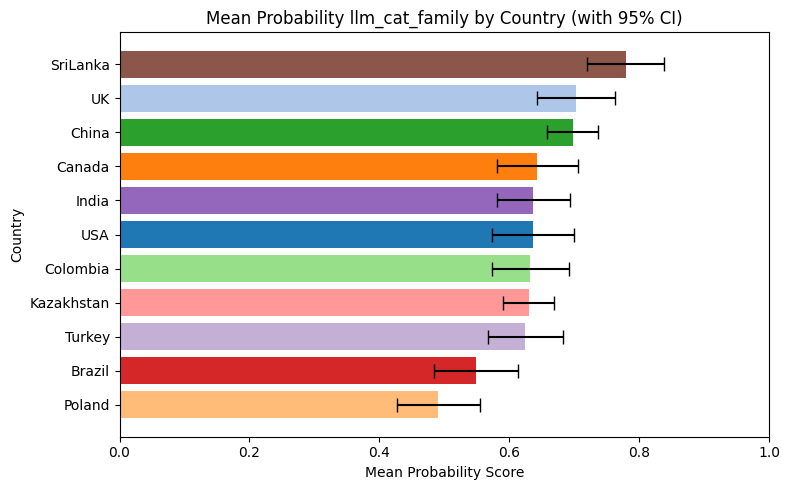

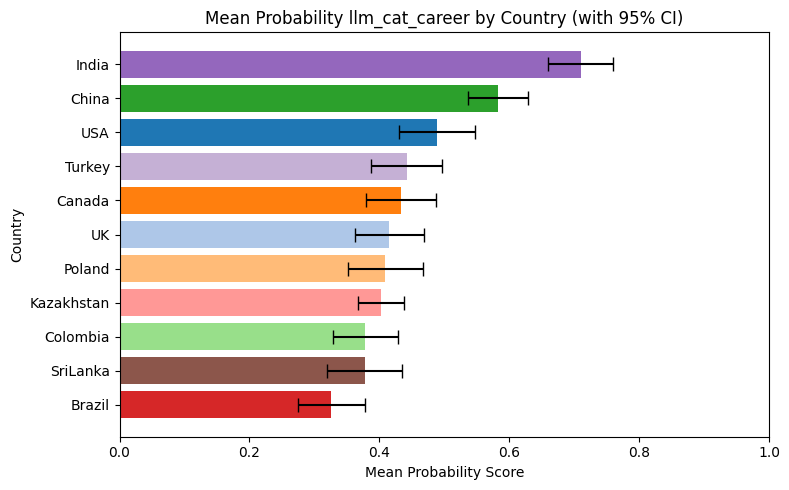

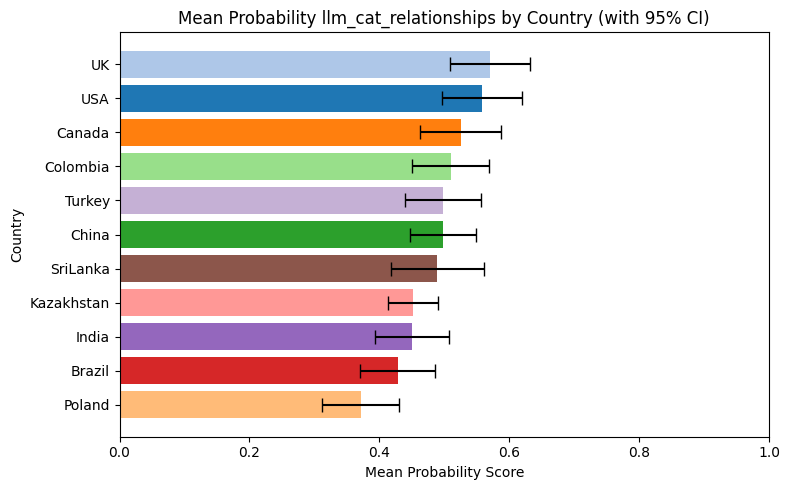

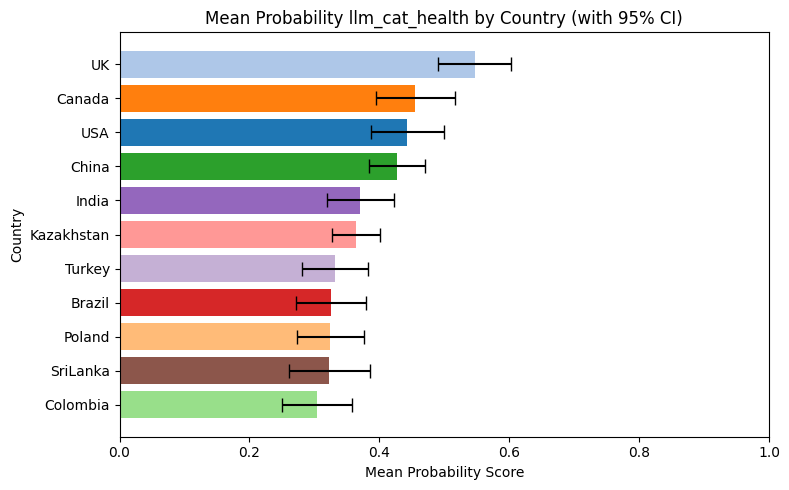

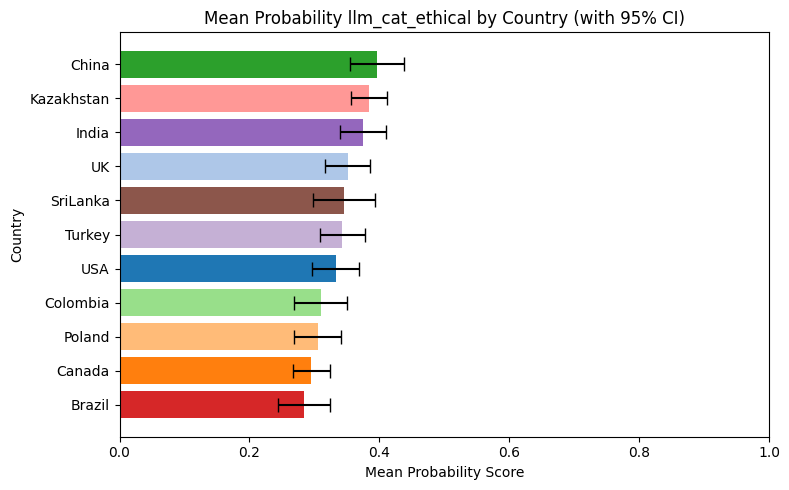

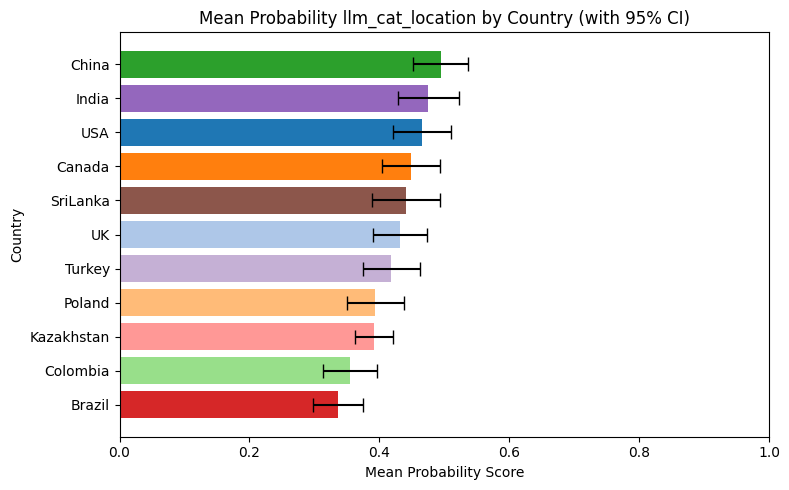

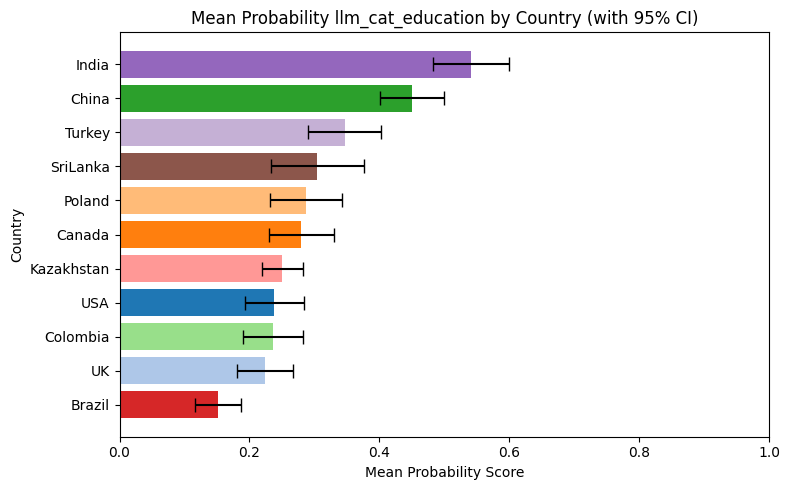

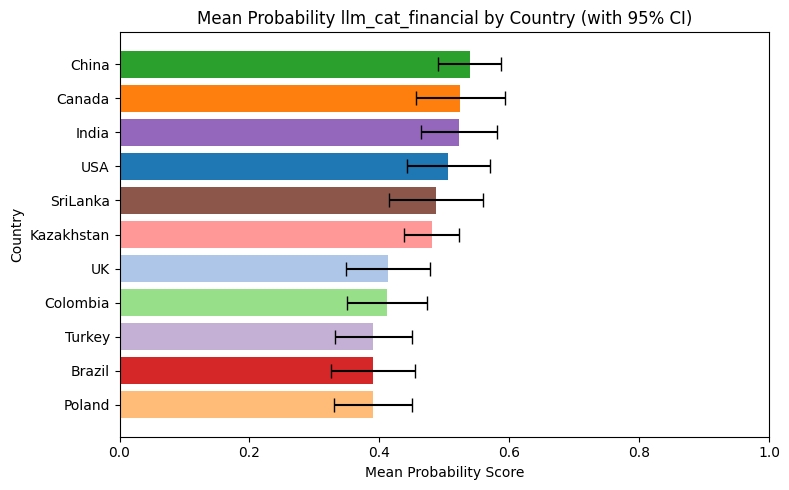

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# List of llm_cat columns (excluding 'llm_category' which is the label, not a score)
llm_cat_vars = [col for col in merged_df.columns if col.startswith('llm_cat_') and col != 'llm_category']

# Assign a color to each country
countries = merged_df['country'].unique()
colors = plt.cm.tab20.colors  # Up to 20 distinct colors
country_color_map = {country: colors[i % len(colors)] for i, country in enumerate(countries)}

for cat_var in llm_cat_vars:
    # Compute mean and SEM per country
    stats = merged_df.groupby('country')[cat_var].agg(['mean', 'sem']).dropna()
    stats = stats.sort_values('mean', ascending=False)
    means = stats['mean']
    sems = stats['sem']
    cis = 1.96 * sems  # 95% confidence interval

    plt.figure(figsize=(8, 5))
    bar_colors = [country_color_map[country] for country in means.index]
    plt.barh(means.index, means, xerr=cis, color=bar_colors, capsize=5)
    plt.gca().invert_yaxis()  # Highest at top
    plt.title(f"Mean Probability {cat_var} by Country (with 95% CI)")
    plt.xlabel("Mean Probability Score")
    plt.ylabel("Country")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

# Text Classification – Results & Discussion Part I

1. **Family emerges as the most prominent domain** in discussions of difficult life decisions across countries, with the highest mean probability of entailment from the zero-shot classifier.  
    - **Sri Lanka**, followed by the **UK** and **China**, show the strongest tendency to reference family—either as the central issue or as a key factor in difficult decisions.
2. **Career** and **Education** is most frequently discussed in responses from India and China , while **relationships** and **health** are most often referenced by USA, UK and Canada. The former is indicative of the high importance given to education 
3. The results highlight the universal importance of family in major life decisions.
4. It is important to recognize that these results reflect what respondents perceive as difficult or confusing in their lives, which may be shaped by cultural context. For example, the fact that Indian and Chinese participants talk more about career-related issues does not necessarily mean they prioritize competence, achievement, or power above all else, or that they neglect other life domains. Rather, career decisions may carry higher stakes for social judgment in these cultures. Conversely, in Canada, the UK, and the USA, relationships with family and others may be more frequently discussed because these aspects are seen as more central to how individuals are evaluated within their cultural context.

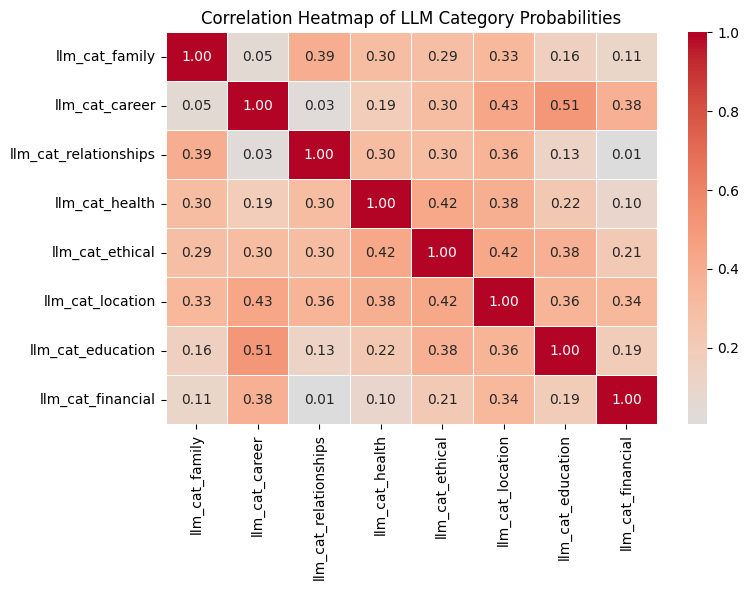

,Category 1,Category 2,Correlation
11,career,education,0.509805
10,career,location,0.430847
18,health,ethical,0.422268
22,ethical,location,0.422005
1,family,relationships,0.391723
19,health,location,0.382884
12,career,financial,0.381748
23,ethical,education,0.378386
15,relationships,location,0.357007
25,location,education,0.356561


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for LLM category variables
llm_corr = merged_df[llm_cat_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(llm_corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of LLM Category Probabilities")
plt.tight_layout()
plt.show()

# Create a table of correlation pairs (excluding self-correlation and duplicates)
corr_pairs = (
    llm_corr.where(~np.eye(llm_corr.shape[0], dtype=bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Category 1', 'Category 2', 'Correlation']

# Keep only the part after the second underscore
def after_second_underscore(s):
    parts = s.split('_', 2)
    return parts[2] if len(parts) > 2 else s

corr_pairs['Category 1'] = corr_pairs['Category 1'].apply(after_second_underscore)
corr_pairs['Category 2'] = corr_pairs['Category 2'].apply(after_second_underscore)

# Remove duplicate pairs (e.g., (A, B) and (B, A)), keep only one
corr_pairs['pair'] = corr_pairs.apply(lambda row: tuple(sorted([row['Category 1'], row['Category 2']])), axis=1)
corr_pairs = corr_pairs.drop_duplicates('pair').drop(columns='pair').reset_index(drop=True)

# Sort by absolute correlation value in descending order
corr_pairs_sorted = corr_pairs.reindex(corr_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Display the sorted correlation table
display(corr_pairs_sorted)


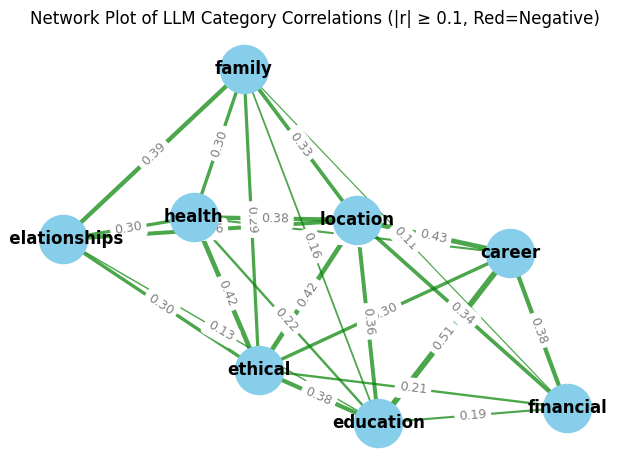

,Category,Degree,Betweenness,Closeness,Eigenvector
0,family,0.857143,0.021429,0.875000,0.353440
1,career,0.714286,0.009524,0.777778,0.302460
2,relationships,0.714286,0.000000,0.777778,0.310821
3,health,0.857143,0.021429,0.875000,0.353440
4,ethical,1.000000,0.042857,1.000000,0.396058
5,location,1.000000,0.042857,1.000000,0.396058
6,education,1.000000,0.042857,1.000000,0.396058
7,financial,0.714286,0.009524,0.777778,0.302460


In [83]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Use the correlation matrix for llm_cat_vars
corrmat = llm_corr.copy()
np.fill_diagonal(corrmat.values, 0)

# Set threshold for absolute correlation
threshold = 0.1

# Create a graph from the correlation matrix (with threshold)
G = nx.Graph()
cat_labels = [col.replace('llm_cat_', '') for col in llm_cat_vars]
for cat in cat_labels:
    G.add_node(cat)

# Add edges above threshold (absolute value)
for i, cat1 in enumerate(cat_labels):
    for j, cat2 in enumerate(cat_labels):
        if i < j:
            weight = corrmat.iloc[i, j]
            if abs(weight) >= threshold:
                G.add_edge(cat1, cat2, weight=weight)

# Node positions
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200)

# Draw edges with width proportional to |correlation|, color by sign
edges = G.edges(data=True)
edge_colors = ['green' if d['weight'] > 0 else 'red' for (_, _, d) in edges]
edge_widths = [abs(d['weight'])*8 for (_, _, d) in edges]  # scale up for visibility
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels (correlation values)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray', font_size=9)

plt.title(f"Network Plot of LLM Category Correlations (|r| ≥ {threshold}, Red=Negative)")
plt.axis('off')
plt.tight_layout()
plt.show()

# --- Centrality Indices ---
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality_numpy(G)

centrality_df = pd.DataFrame({
    'Category': list(G.nodes),
    'Degree': [centrality[n] for n in G.nodes],
    'Betweenness': [betweenness[n] for n in G.nodes],
    'Closeness': [closeness[n] for n in G.nodes],
    'Eigenvector': [eigenvector[n] for n in G.nodes]
})

# Display the table
display(centrality_df)

## Network Centrality Results: Domains in Difficult Life Decisions
An undirected, weighted correlation network based was estimated. Each node represents a domain that participants referenced when describing their most difficult life decisions.

Centrality analysis revealed:

- Ethical, Location, and Education domains were the most central in the network, each with the highest degree centrality (1.00), closeness centrality (1.00), and eigenvector centrality (0.40). This indicates that discussions of difficult decisions frequently involved these domains and that they are strongly interconnected with other life areas.
- Family and Health also showed high centrality (degree = 0.86, closeness = 0.88, eigenvector = 0.35), suggesting these topics are not only common but also well-integrated with other domains in people’s narratives about difficult choices.
- Career, Relationships, and Financial domains were somewhat less central (degree = 0.71, closeness = 0.78, eigenvector = 0.30–0.31), indicating that while important, they tend to be discussed more independently or less frequently in conjunction with other domains.
- Betweenness centrality values were generally low for all nodes (ranging from 0.00 to 0.04), suggesting that no single domain acts as a critical bridge between others; rather, the network is relatively well-connected.

The relevance of Family and Health resonates with the Topic Modeling analysis. The centrality of Ethical, Location and Education domains is reflective of the difficulties common among student populations – largely representative of the current samples. 

# 2. LLM-based Zero-Shot Text Classification Approach

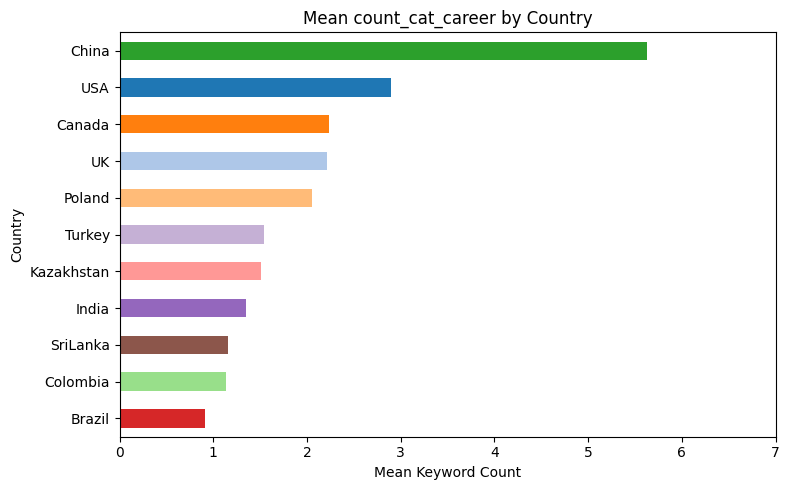

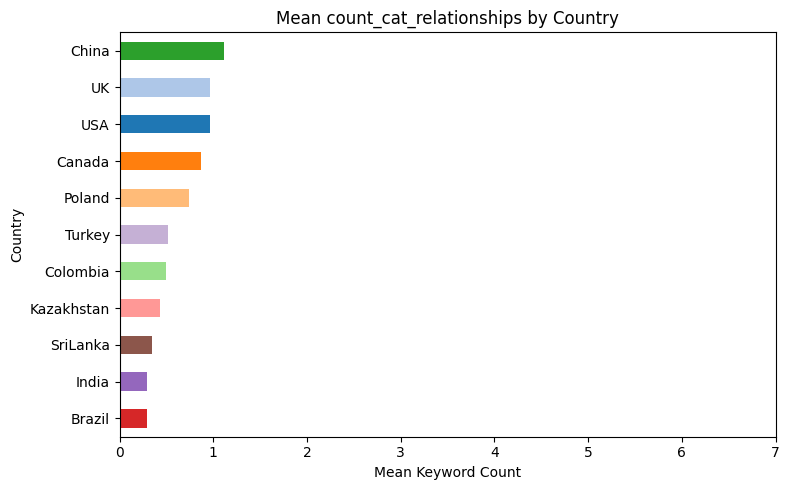

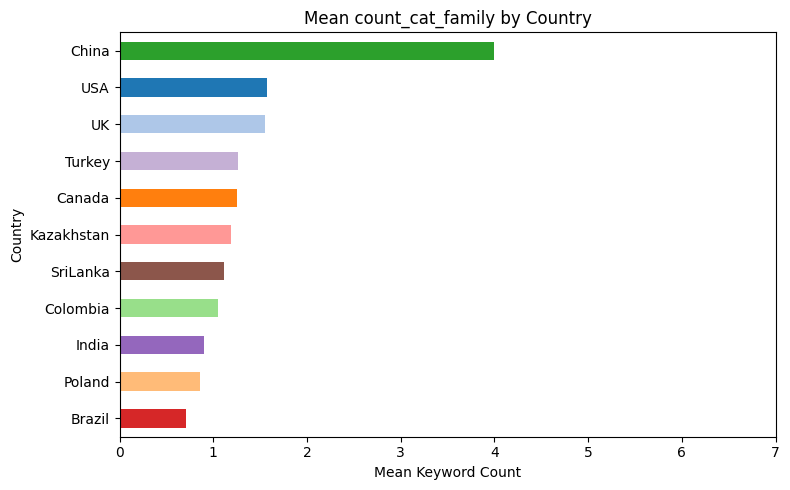

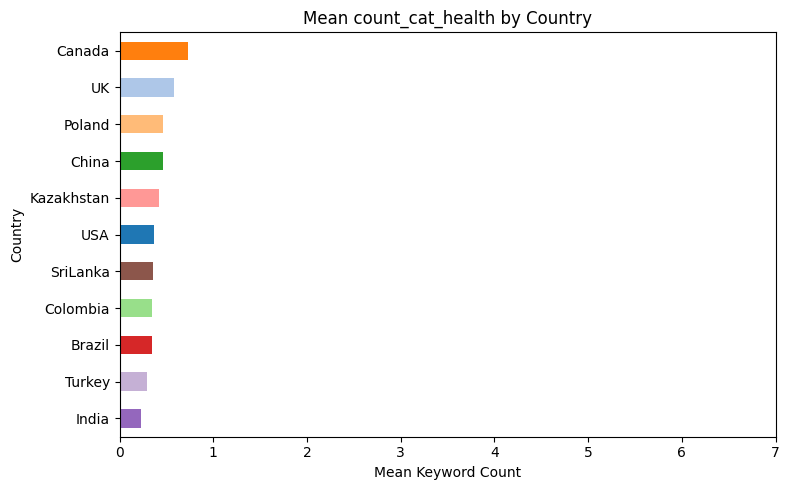

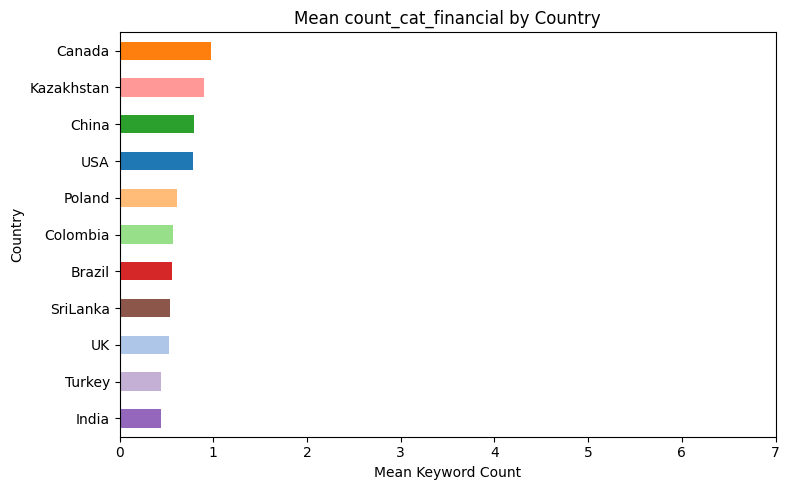

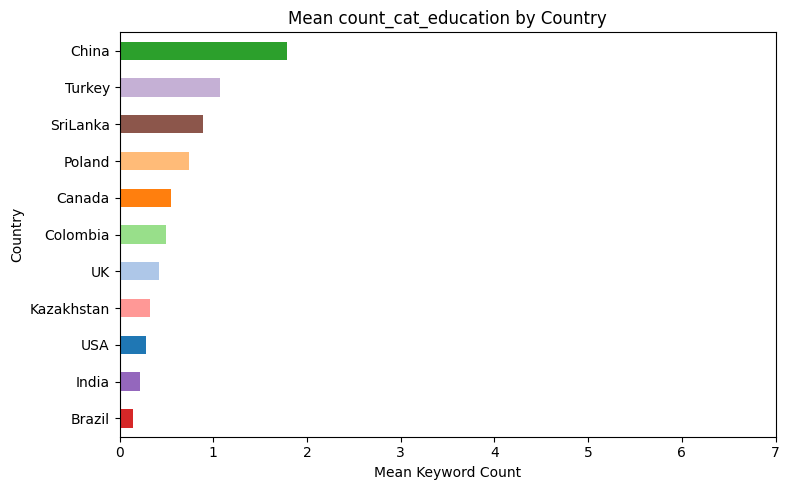

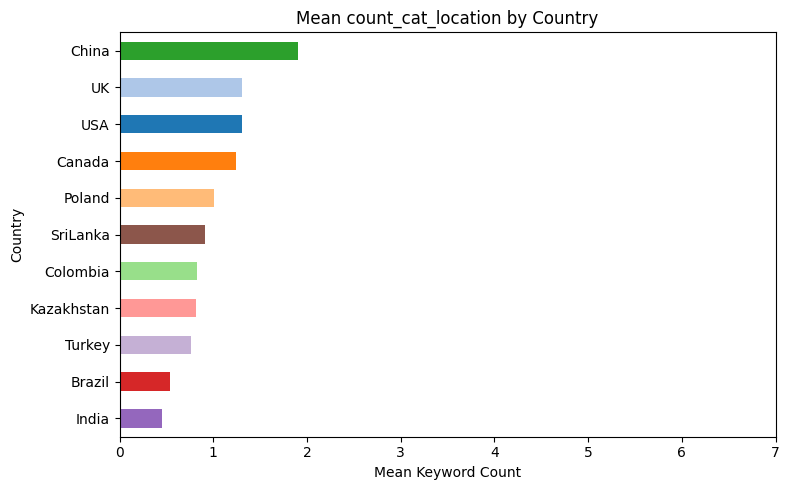

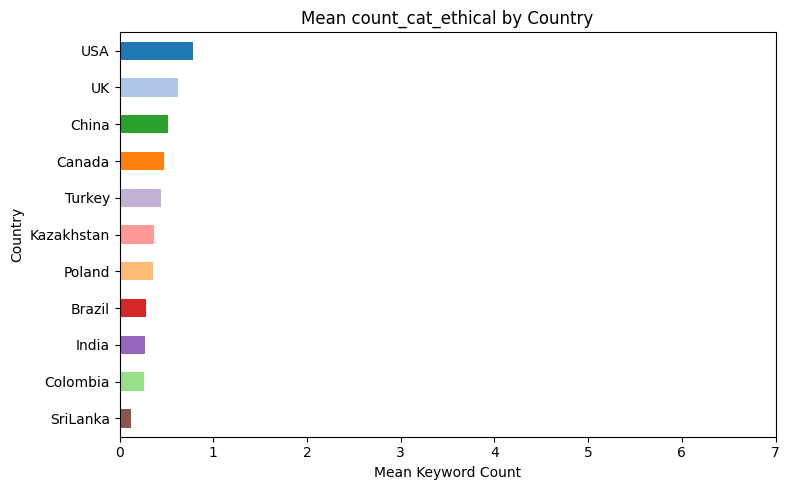

In [84]:
import matplotlib.pyplot as plt

# List of count_cat columns (count-based category scores) from merged_df
count_cat_vars = [col for col in merged_df.columns if col.startswith('count_cat_')]

# For each count_cat variable, plot country-wise mean score as a horizontal bar chart
for count_var in count_cat_vars:
    # Compute mean score per country, drop NaN
    country_means = merged_df.groupby('country')[count_var].mean().dropna()
    # Sort descending
    country_means = country_means.sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))
    bar_colors = [country_color_map[country] for country in country_means.index]
    country_means.plot(kind='barh', color=bar_colors)
    plt.gca().invert_yaxis()  # Highest at top
    plt.title(f"Mean {count_var} by Country")
    plt.xlabel("Mean Keyword Count")
    plt.ylabel("Country")
    plt.xlim(0, 7)  # Set scale from 0 to 7
    plt.tight_layout()
    plt.show()

# Text Classification – Results & Discussion Part II


# TOPIC MODELING

In [2]:
import pandas as pd

# Load the merged dataframe from Excel
merged_df = pd.read_excel("/Users/vinitavader/Desktop/WJC/data/merged_Wave1_text_classification.xlsx")

# Count non-missing Open_Q1_Q7 responses by country
open_q_counts = merged_df.groupby('country')["Open_Q1_Q7"].count().sort_values(ascending=False)


# Create Open_Q1 to Q4 using LB fallback to SMB
for i in range(1, 5):
    merged_df[f"Open_Q{i}"] = (
        merged_df.get(f"LB_Open_Q{i}").fillna(merged_df.get(f"SMB_Open_Q{i}"))
    )

# Concatenate Open_Q1 to Open_Q4 into a single column
merged_df["Open_Q1_Q4"] = merged_df[[f"Open_Q{i}" for i in range(1, 5)]].apply(
    lambda row: ' '.join(row.dropna().astype(str)), axis=1
)
print(open_q_counts) 
merged_df.Open_Q1_Q4


country
Kazakhstan    330
India         166
Colombia      158
Poland        156
China         155
Canada        150
USA           150
Turkey        149
UK            149
Brazil        143
SriLanka       97
Name: Open_Q1_Q7, dtype: int64


0       The difficult desicion was about wether to acc...
1       I got a Job with another company 3 months ago,...
2       A difficult decision I faced was the choice to...
3       My decision to quit drinking alcohol. I was pr...
4       I needed to decide whether to retire and move ...
                              ...                        
2066    Four years ago, I lost my job due to the loss ...
2067    Stopping school education after father's death...
2068    The hardest decision I ever made in my life wa...
2069    Māvā care. From about 2023. Damage to the back...
2070    The hardest decision I made in my life was to ...
Name: Open_Q1_Q4, Length: 2071, dtype: object

## 1. Preprocessing
Clean text: remove stopwords, punctuation, special characters, and extra whitespace.
 clean_text function; apply  to Open_Q1_Q7.

In [3]:
# Add to your preprocessing cell before topic modeling

import re
def clean_text(text):
    """Clean XML artifacts from text while preserving NA handling"""
    if pd.isna(text) or text == 'nan':
        return pd.NA
    
    # Convert to string and clean XML artifacts
    text = str(text)
    
    # Remove XML space preserve tags and entities
    text = re.sub(r'xml:space="preserve">', '', text)
    text = re.sub(r'&#xa;', ' ', text)  # Replace line breaks with spaces
    text = re.sub(r'&[a-zA-Z]+;', ' ', text)  # Remove other XML entities
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Return NA if text becomes empty after cleaning
    return pd.NA if text == '' else text

# Add generic verbs/stopwords to remove
GENERIC_WORDS = [
    r"\bdid\b", r"\bmake\b", r"\bmade\b", r"\bwas\b", r"\bwere\b", r"\bhas\b", r"\bhad\b", r"\bhave\b", r"\bwasn\b", r"\blet\b",
    r"\bget\b", r"\bgot\b", r"\bgetting\b", r"\bgotten\b", r"\bdo\b", r"\bdoes\b", r"\bdoing\b", r"\bgo\b", r"\bgoing\b", r"\blike\b", r"\bsaid\b", r"\bdon\b"
]

def remove_generic_phrases(text):
    if pd.isna(text):
        return text
    text = str(text).lower()
    # Remove full phrases first
    phrases = [
        r"most difficult decision",
        r"hardest decision",
        r"most difficult",
        r"hardest",
        r"make decisions",
        r"_x000d_"
    ]
    for phrase in phrases:
        text = re.sub(phrase, '', text)
    # Remove single words and generic verbs
    words = [
        r"\bdecision\b",
        r"\bdifficult\b",
        r"\bhardest\b",
        r"\bdidn\b",
        r"\bdecisions\b",
        r"\bfelt\b", # removing felt and think (and realted words) as they are often used in response to Q4 and Q5
        r"\bfeel\b",
        r"\bfeeling\b",
        r"\bthink\b",
        r"\bthinking\b",
        r"\bthought\b",
        r"\bthoughts\b"
    ] + GENERIC_WORDS
    for word in words:
        text = re.sub(word, '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else pd.NA

# Apply to your column before topic modeling
merged_df["Open_Q1_Q4_clean"] = (
    merged_df["Open_Q1_Q4"]
    .apply(clean_text)  # your existing cleaning
    .apply(remove_generic_phrases)
)

merged_df["Open_Q1_Q7_clean"] = (
    merged_df["Open_Q1_Q7"]
    .apply(clean_text)
    .apply(remove_generic_phrases)
)


## 2. BERTopic Pipeline
Use outlined steps for embedding, dimensionality reduction, clustering, and topic modeling.

In [4]:

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

docs = merged_df['Open_Q1_Q4_clean'].dropna().tolist()

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = umap.UMAP(n_neighbors=30, n_components=3, min_dist=0.1, metric='cosine')
# 2. Tune HDBSCAN parameters (for more/fewer initial topics)
# Increase min_cluster_size to get fewer, larger topics.
# Decrease min_cluster_size to get more, smaller topics.
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=10, metric='euclidean', cluster_selection_method='leaf', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words='english', min_df=5, ngram_range=(1,3))
ctfidf_model = ClassTfidfTransformer()
representation_model = MaximalMarginalRelevance(diversity=0.8)

topic_model = BERTopic(
  embedding_model=sbert_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model,
  calculate_probabilities=True,
  verbose=True
)

topics, probs = topic_model.fit_transform(docs)

# Reduce the number of topics to 10
topic_model.reduce_topics(docs, nr_topics=8)


2025-06-24 07:07:28,388 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/57 [00:00<?, ?it/s]

2025-06-24 07:07:33,639 - BERTopic - Embedding - Completed ✓
2025-06-24 07:07:33,639 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-24 07:07:37,477 - BERTopic - Dimensionality - Completed ✓
2025-06-24 07:07:37,478 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-24 07:07:37,519 - BERTopic - Cluster - Completed ✓
2025-06-24 07:07:37,521 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-24 07:07:38,518 - BERTopic - Representation - Completed ✓
2025-06-24 07:07:38,630 - BERTopic - Topic reduction - Reducing number of topics
2025-06-24 07:07:38,635 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-24 07:07:39,014 - BERTopic - Representation - Completed ✓
2025-06-24 07:07:39,016 - BERTopic - Topic reduction - Reduced number of topics from 13 to 8


In [5]:
# See how many documents are in the 'docs' list
print(f"Number of documents in docs: {len(docs)}")

Number of documents in docs: 1801


In [6]:
topic_info = topic_model.get_topic_info()
n_topics = (topic_info['Topic'] != -1).sum()
print(f"Number of topics (excluding outliers): {n_topics}")

Number of topics (excluding outliers): 7


## 3. Visualizations
built-in BERTopic plots for interpretation:

In [7]:

# Intertopic distance map (UMAP): Shows the relationship and distance between topics in 2D space.
fig1 = topic_model.visualize_topics()

# Top words per topic: Horizontal bar chart of the most important words for each topic.
fig2 = topic_model.visualize_barchart(n_words=10, top_n_topics = 12) # None means all topics will be shown.
# Ensure all y-axis labels (words) are displayed, even if in small font
fig2.update_yaxes(tickfont=dict(size=7.7))

# Topic similarity heatmap: Visualizes how similar topics are to each other.
fig3 = topic_model.visualize_heatmap()

# Hierarchical clustering of topics: Dendrogram showing topic groupings and hierarchy.
fig4 = topic_model.visualize_hierarchy()

# Documents in topic space: Projects your documents into topic space for exploration.
fig5 = topic_model.visualize_documents(docs)

# Display all plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()


## TOPIC MODELING - RESULTS and DISCUSSION
- Distinct Themes: Six topics were retained 
    0. Family Health: Health related concerns for family members
    1. Work Relocation: A job/work-related move to a new location 
    2. College-related: Concerns about the future in the context of college selection
    3. Relationship [of Romantic type]: Ending of a relationship 
    4. Financial hardship: Loan and income related decisions
    5. Concern about children: Mainly about child's education and one's parenting abilities 
    6. Health concerns: Pain associated with a medical procedure or issues with a health related-problem
   
Overall the model broady reveals clear clusters around family, career and health. Family members/associations are typically meantioned across all topics indicating the strong need and attachment with family and the effect on them thereupon when it comes to difficult decisions.
Overlap: Some topics may show overlap, suggesting interconnectedness (e.g., financial and career decisions).
Country Differences: The distribution of topics may vary by country, reflecting cultural or contextual differences in decision-making, however this can be explored in Study 2 in case of more data per country. 


# AUXILIARY QUESTIONS:

## How frequently is time mentioned in responses?

,country,count,time_phrases
0,China,34,"[2021, 2022, spring of 2018, summer of 2022, i..."
1,Kazakhstan,34,"[2025, summer of 2022, 2025, in 2016, in 2014,..."
2,India,22,"[2025, in 2014, 2006, in 2020, 2024, in 2021, ..."
3,Canada,19,"[in 2022, in 2008, 2025, spring of 2026, 2025,..."
4,SriLanka,19,"[2025, 2025, 2001, in 2009, 2025, in 2012, in ..."
5,Turkey,18,"[in 2019, in 2024, in 2017, 2022, in 2020, sum..."
6,USA,13,"[2025, in 2022, 2020, 2023, 2025, around 2018,..."
7,Brazil,11,"[in 1993, in 1990, in 2017, in 2014, 2019, in ..."
8,Colombia,11,"[in 2005, 1991, in 2008, in 2020, 2023, in 198..."
9,Poland,11,"[2024, 2022, in 2008, 2025, 2024, 2025, in 201..."


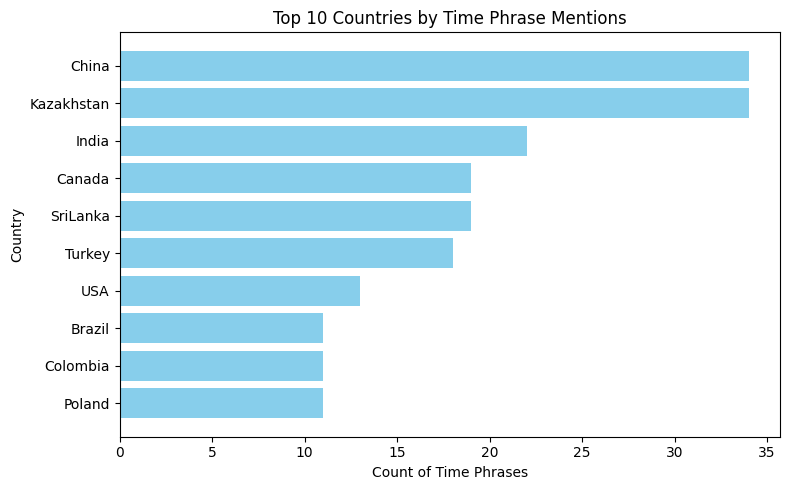

In [99]:
import re
import numpy as np

# --- Extract time-related phrases from Open_Q1_Q7_clean ---

# Define patterns for years and time phrases
time_patterns = [
    r'\b(?:19|20)\d{2}\b',  # years like 1999, 2023
    r'(?:spring|summer|fall|autumn|winter)\s*(?:of)?\s*(?:19|20)\d{2}',  # e.g., summer 2020
    r'(?:in|since|during|around|by|from|until|till|before|after)\s+(?:19|20)\d{2}'  # e.g., in 2021
]
time_regex = re.compile('|'.join(time_patterns), re.IGNORECASE)

# Extract time phrases into a new column
time_phrases_df = merged_df.copy()
time_phrases_df["time_phrases"] = (
    time_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: time_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst[0] if lst else np.nan)
)

# Show the phrases df as before
#display(time_phrases_df[["country", "time_phrases"]])

# Group by country: count and collect phrases, dropping NA/nan phrases
country_time_counts = (
    time_phrases_df.dropna(subset=["time_phrases"])
    .groupby("country")
    .agg(
        count=("time_phrases", "count"),
        time_phrases=("time_phrases", lambda x: list(x))
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_time_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_time_counts["country"], country_time_counts["count"], color="skyblue")
plt.xlabel("Count of Time Phrases")
plt.ylabel("Country")
plt.title("Top 10 Countries by Time Phrase Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## How frequently is religion/god/spirituality mentioned in responses?

,country,count,religion_phrases
0,Kazakhstan,27,"[gods, god, prayed, allah, god, prayed, faith,..."
1,Colombia,22,"[faith, god, god, pray, god, god, god, god, go..."
2,Brazil,19,"[god, pray, faith, god, god, faith, god, spiri..."
3,India,15,"[faith, spiritual, praying, temple, god, bless..."
4,Turkey,10,"[god, spiritual, spiritual, god, prayed, praye..."
5,USA,10,"[faith, prayed, faith, prayed, miracle, god, c..."
6,UK,7,"[church, church, religious, miracle, blessing,..."
7,SriLanka,6,"[religion, temple, religion, religious, spirit..."
8,Canada,5,"[god, praying, god, miracle, prayed, god, god,..."
9,China,3,"[god, god, god]"


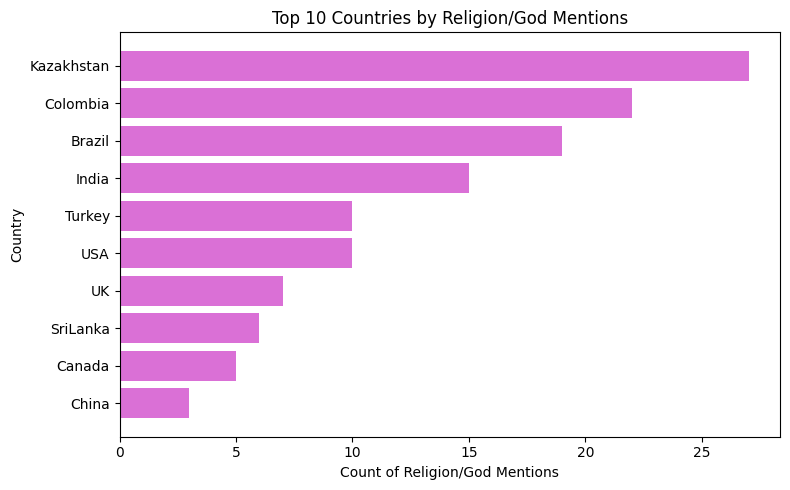

In [8]:
import re
import numpy as np

# --- Extract religion/god-related phrases from Open_Q1_Q7_clean ---

# Define patterns for religion/god-related words/phrases (including allah, alla, jesus, etc.)
religion_patterns = [
    r'\bgod\b', r'\bgods\b', r'\bjesus\b', r'\bchrist\b', r'\ballah\b', r'\balla\b', r'\bprophet\b', r'\bfaith\b',
    r'\bpray\b', r'\bprayer\b', r'\bprayed\b', r'\bpraying\b', r'\bchurch\b', r'\btemple\b', r'\bmosque\b',
    r'\bspiritual\b', r'\breligion\b', r'\breligious\b', r'\bdivine\b', r'\bbless\b', r'\bblessing\b',
    r'\bmiracle\b', r'\bholy\b', r'\bscripture\b', r'\bquran\b', r'\bbible\b', r'\bbhagavad\b', r'\bgita\b',
    r'\bkarma\b', r'\bpuja\b', r'\bshiva\b', r'\bkrishna\b', r'\bdeity\b', r'\bsaint\b', r'\bspirit\b'
]
religion_regex = re.compile('|'.join(religion_patterns), re.IGNORECASE)

# Extract religion/god-related phrases into a new column
religion_phrases_df = merged_df.copy()
religion_phrases_df["religion_phrases"] = (
    religion_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: religion_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_religion_counts = (
    religion_phrases_df.dropna(subset=["religion_phrases"])
    .groupby("country")
    .agg(
        count=("religion_phrases", "count"),
        religion_phrases=("religion_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_religion_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_religion_counts["country"], country_religion_counts["count"], color="orchid")
plt.xlabel("Count of Religion/God Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Religion/God Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## How frequently is divorced/separation mentioned in responses?

,country,count,divorce_phrases
0,Kazakhstan,35,"[divorce, divorce, divorce, separating, separa..."
1,China,20,"[separation, separation, broke up, separated, ..."
2,Colombia,17,"[separation, marital separation, separation, e..."
3,Turkey,17,"[ex-wife, separation, breakup, broke up, divor..."
4,Brazil,12,"[divorce, separated, ex-wife, divorce, separat..."
5,USA,12,"[ex-husband, separated, broke up, separated, d..."
6,Canada,11,"[broke up, broke up, divorce, divorce, ex-husb..."
7,Poland,9,"[broke up, broke up, breakup, broke up, separa..."
8,UK,9,"[divorce, ex-wife, divorce, divorce, divorcing..."
9,SriLanka,6,"[separated, breakup, separated, separated, div..."


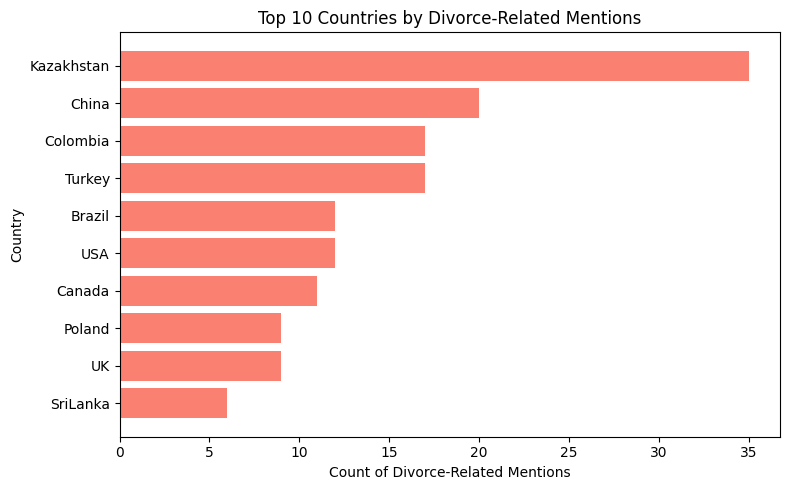

In [9]:
import re
import numpy as np

# --- Extract divorce-related phrases from Open_Q1_Q7_clean ---

# Define patterns for divorce and related words/phrases
divorce_patterns = [
    r'\bdivorce\b', r'\bdivorced\b', r'\bdivorcing\b', r'\bseparation\b', r'\bseparated\b',
    r'\bseparating\b', r'\bmarital separation\b', r'\bmarriage ended\b', r'\bmarriage break\b',
    r'\bmarriage breakdown\b', r'\bmarriage dissolution\b', r'\bspouse left\b', r'\bspousal separation\b',
    r'\bex-husband\b', r'\bex-wife\b', r'\bex spouse\b', r'\bex-partner\b', r'\bleft my spouse\b',
    r'\bleft my husband\b', r'\bleft my wife\b', r'\bbroke up\b', r'\bbreakup\b'
]
divorce_regex = re.compile('|'.join(divorce_patterns), re.IGNORECASE)

# Extract divorce-related phrases into a new column
divorce_phrases_df = merged_df.copy()
divorce_phrases_df["divorce_phrases"] = (
    divorce_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: divorce_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_divorce_counts = (
    divorce_phrases_df.dropna(subset=["divorce_phrases"])
    .groupby("country")
    .agg(
        count=("divorce_phrases", "count"),
        divorce_phrases=("divorce_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_divorce_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_divorce_counts["country"], country_divorce_counts["count"], color="salmon")
plt.xlabel("Count of Divorce-Related Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Divorce-Related Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## How frequently is friend mentioned in responses?

,country,count,friend_phrases
0,Kazakhstan,65,"[friends, friend, friends, friends, friends, c..."
1,China,61,"[friends, friends, friend, friends, friends, f..."
2,Canada,56,"[friends, friends, friends, childhood friends,..."
3,USA,55,"[friends, friendship, friends, friends, friend..."
4,India,52,"[friends, friends, friends, friends, friends, ..."
5,Poland,50,"[friends, friends, friends, new friends, frien..."
6,UK,49,"[friends, friends, friend, friend, friend, fri..."
7,Turkey,31,"[friends, close friend, friends, friends, frie..."
8,Brazil,19,"[friends, friend, friends, friend, friend, fri..."
9,SriLanka,14,"[friend, friends, friends, friends, friend, fr..."


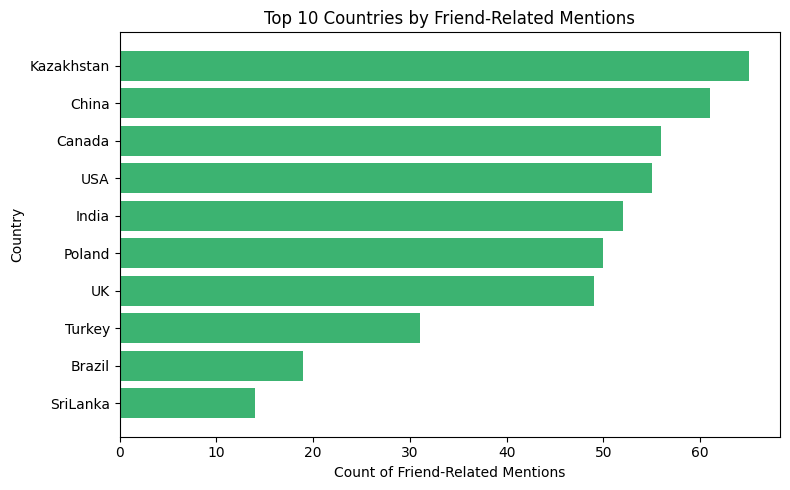

In [10]:
import re
import numpy as np

# --- Extract friend-related phrases from Open_Q1_Q7_clean ---

# Define patterns for friend and related words/phrases
friend_patterns = [
    r'\bfriend\b', r'\bfriends\b', r'\bfriendship\b', r'\bbest friend\b', r'\bbestfriend\b',
    r'\bclose friend\b', r'\bclose friends\b', r'\bex-friend\b', r'\bex friend\b',
    r'\bmake friends\b', r'\bmaking friends\b', r'\blost friend\b', r'\blost friends\b',
    r'\bfalling out\b', r'\bfell out\b', r'\bfriendly\b', r'\bunfriend\b', r'\bunfriended\b',
    r'\bnew friend\b', r'\bnew friends\b', r'\bchildhood friend\b', r'\bchildhood friends\b'
]
friend_regex = re.compile('|'.join(friend_patterns), re.IGNORECASE)

# Extract friend-related phrases into a new column
friend_phrases_df = merged_df.copy()
friend_phrases_df["friend_phrases"] = (
    friend_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: friend_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_friend_counts = (
    friend_phrases_df.dropna(subset=["friend_phrases"])
    .groupby("country")
    .agg(
        count=("friend_phrases", "count"),
        friend_phrases=("friend_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_friend_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_friend_counts["country"], country_friend_counts["count"], color="mediumseagreen")
plt.xlabel("Count of Friend-Related Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Friend-Related Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## How frequently is mother/father/parents mentioned in responses?

,country,count,parent_phrases
0,Kazakhstan,99,"[parents, parents, parents, parents, parents, ..."
1,China,76,"[parents, parents, parents, parents, parents, ..."
2,India,54,"[parents, parents, parents, parent, father, fa..."
3,Canada,47,"[parents, parents, parents, father, father, mo..."
4,USA,46,"[parents, parents, dad, mother, dad, mom, mom,..."
5,SriLanka,44,"[parents, parents, father, dad, father, mother..."
6,UK,43,"[parents, parents, father, parents, mum, mum, ..."
7,Poland,38,"[parents, parents, parents, mother, mother, pa..."
8,Turkey,36,"[mother, father, mother, father, father, fathe..."
9,Colombia,35,"[mother, mother, mother, mother, mother, paren..."


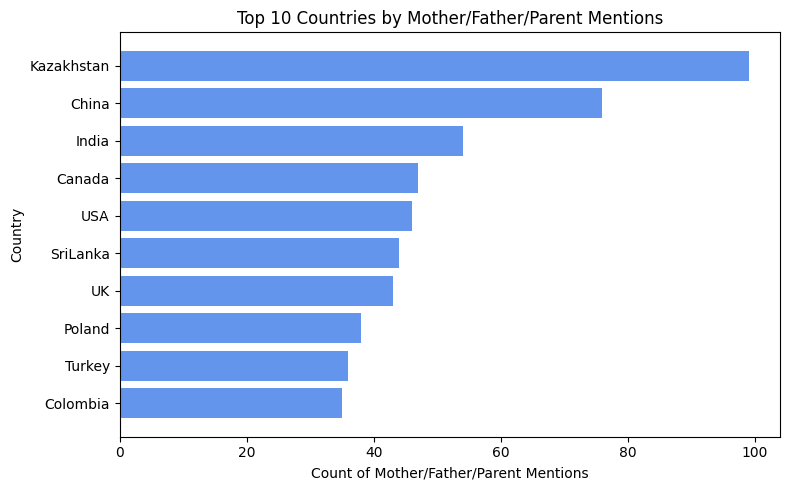

In [11]:
import re
import numpy as np

# --- Extract mother/father/parent-related phrases from Open_Q1_Q7_clean ---

# Define patterns for mother, father, parent and related words/phrases
parent_patterns = [
    r'\bmother\b', r'\bmom\b', r'\bmum\b', r'\bma\b', r'\bmama\b', r'\bmatriarch\b',
    r'\bfather\b', r'\bdad\b', r'\bdaddy\b', r'\bpapa\b', r'\bpa\b', r'\bpatriarch\b',
    r'\bparent\b', r'\bparents\b', r'\bparenting\b', r'\bstepmother\b', r'\bstepmom\b',
    r'\bstepfather\b', r'\bstepdad\b', r'\bstepparent\b', r'\bstepparents\b',
    r'\bfoster mother\b', r'\bfoster father\b', r'\bfoster parent\b', r'\bfoster parents\b',
    r'\badoptive mother\b', r'\badoptive father\b', r'\badoptive parent\b', r'\badoptive parents\b',
    r'\bguardian\b', r'\bguardians\b'
]
parent_regex = re.compile('|'.join(parent_patterns), re.IGNORECASE)

# Extract parent-related phrases into a new column
parent_phrases_df = merged_df.copy()
parent_phrases_df["parent_phrases"] = (
    parent_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: parent_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_parent_counts = (
    parent_phrases_df.dropna(subset=["parent_phrases"])
    .groupby("country")
    .agg(
        count=("parent_phrases", "count"),
        parent_phrases=("parent_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_parent_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_parent_counts["country"], country_parent_counts["count"], color="cornflowerblue")
plt.xlabel("Count of Mother/Father/Parent Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Mother/Father/Parent Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## How frequently is depression/sad mentioned in responses?

,country,count,depression_phrases
0,Kazakhstan,89,"[sadness, cried, sad, lonely, depressed, lonel..."
1,Canada,76,"[loneliness, down, sad, grief, grief, down, do..."
2,UK,70,"[blue, sad, miserable, sadness, sad, down, mis..."
3,Colombia,63,"[sadness, melancholy, cried, grief, sadness, s..."
4,USA,62,"[lonely, hopeless, sadness, sadness, down, dow..."
5,Poland,57,"[sad, down, despair, despair, depression, lone..."
6,Turkey,53,"[down, down, sadness, saddened, sad, crying, d..."
7,China,46,"[sad, down, depression, down, sadness, sadness..."
8,India,41,"[down, down, down, miserable, sad, depressed, ..."
9,Brazil,40,"[down, sad, down, sadness, sad, despair, sadne..."


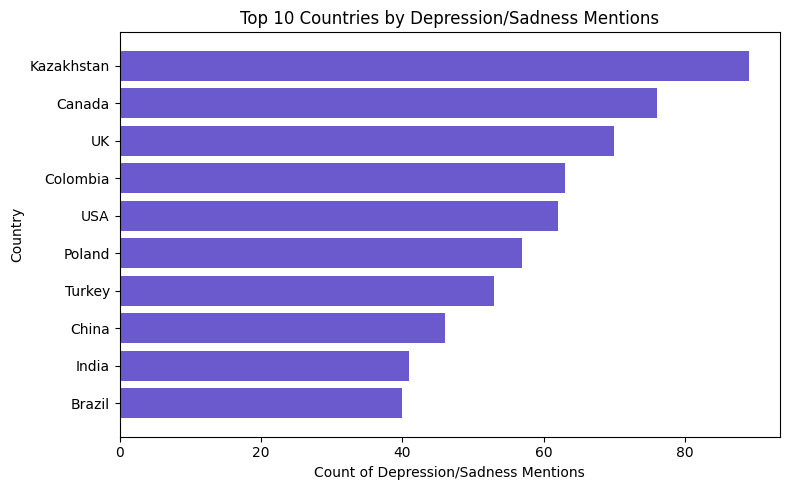

In [12]:
import re
import numpy as np

# --- Extract depression/sadness-related phrases from Open_Q1_Q7_clean ---

# Define patterns for depression, sadness, and related words/phrases
depression_patterns = [
    r'\bdepression\b', r'\bdepressed\b', r'\bdepressive\b', r'\bdepressing\b',
    r'\bsad\b', r'\bsadness\b', r'\bsaddened\b', r'\bsaddening\b',
    r'\bmelancholy\b', r'\bmelancholic\b', r'\bdown\b', r'\bfeeling down\b',
    r'\bblue\b', r'\bfeeling blue\b', r'\btearful\b', r'\bcrying\b',
    r'\bcried\b', r'\bcries\b', r'\bgrief\b', r'\bgrieving\b', r'\bdespair\b',
    r'\bhopeless\b', r'\bhopelessness\b', r'\blonely\b', r'\bloneliness\b',
    r'\bmisery\b', r'\bmiserable\b', r'\bheartbroken\b', r'\bheartbreak\b'
]
depression_regex = re.compile('|'.join(depression_patterns), re.IGNORECASE)

# Extract depression/sadness-related phrases into a new column
depression_phrases_df = merged_df.copy()
depression_phrases_df["depression_phrases"] = (
    depression_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: depression_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_depression_counts = (
    depression_phrases_df.dropna(subset=["depression_phrases"])
    .groupby("country")
    .agg(
        count=("depression_phrases", "count"),
        depression_phrases=("depression_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_depression_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_depression_counts["country"], country_depression_counts["count"], color="slateblue")
plt.xlabel("Count of Depression/Sadness Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Depression/Sadness Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## How frequently is happy mentioned in responses?

,country,count,happy_phrases
0,Kazakhstan,50,"[happiness, satisfaction, glad, happy, happy, ..."
1,UK,38,"[happiness, happy, joy, happy, satisfaction, h..."
2,India,37,"[happy, happy, satisfaction, happy, happy, hap..."
3,Turkey,37,"[happy, happiness, glad, happier, happier, hap..."
4,Canada,33,"[happy, happiest, happy, glad, glad, elated, h..."
5,China,33,"[satisfied, content, happy, content, content, ..."
6,Poland,29,"[satisfaction, happy, joy, happy, happy, happy..."
7,USA,28,"[glad, satisfaction, happy, glad, happier, sat..."
8,Colombia,16,"[happy, happy, happy, happy, happy, joy, satis..."
9,Brazil,14,"[happy, satisfied, happy, happy, joy, happy, j..."


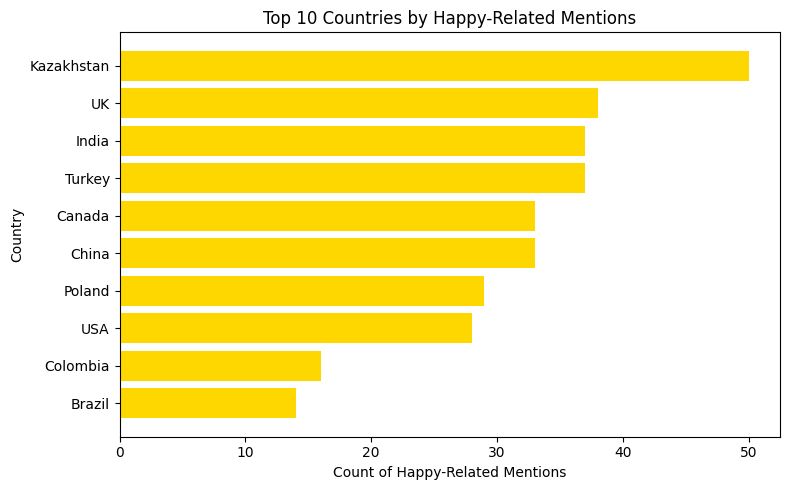

In [13]:
import re
import numpy as np

# --- Extract happiness/joy-related phrases from Open_Q1_Q7_clean ---

# Define patterns for happy, happiness, joy, and related words/phrases
happy_patterns = [
    r'\bhappy\b', r'\bhappier\b', r'\bhappiest\b', r'\bhappiness\b', r'\bjoy\b', r'\bjoyful\b',
    r'\bjoyous\b', r'\bcheerful\b', r'\bcheerfulness\b', r'\bdelight\b', r'\bdelighted\b',
    r'\bcontent\b', r'\bcontented\b', r'\bcontentment\b', r'\bpleased\b', r'\bpleasure\b',
    r'\bglad\b', r'\bglee\b', r'\bgleeful\b', r'\belated\b', r'\belation\b', r'\bbliss\b',
    r'\bblissful\b', r'\bgratified\b', r'\bsatisfied\b', r'\bsatisfaction\b', r'\bsmile\b', r'\bsmiling\b'
]
happy_regex = re.compile('|'.join(happy_patterns), re.IGNORECASE)

# Extract happy-related phrases into a new column
happy_phrases_df = merged_df.copy()
happy_phrases_df["happy_phrases"] = (
    happy_phrases_df["Open_Q1_Q7_clean"]
    .apply(lambda x: happy_regex.findall(str(x)) if pd.notna(x) else [])
    .apply(lambda lst: lst if lst else np.nan)
)

# Group by country: count and collect phrases, dropping NA/nan phrases
country_happy_counts = (
    happy_phrases_df.dropna(subset=["happy_phrases"])
    .groupby("country")
    .agg(
        count=("happy_phrases", "count"),
        happy_phrases=("happy_phrases", lambda x: sum(x, []))  # flatten lists
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index()
)

display(country_happy_counts)

# Plot: Country on y-axis, count on x-axis (horizontal bar plot)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(country_happy_counts["country"], country_happy_counts["count"], color="gold")
plt.xlabel("Count of Happy-Related Mentions")
plt.ylabel("Country")
plt.title("Top 10 Countries by Happy-Related Mentions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()